# Training GNNs on Large Graphs

We have seen the example of training GNNs on the entire graph.  However, usually our graph is very big: it could contain millions or billions of nodes and edges.  The storage required for the graph would be many times bigger if we consider node and edge features.  If we want to utilize GPUs for faster computation, we would notice that full graph training is often impossible on GPUs because our graph and features cannot fit into a single GPU.  Not to mention that the node representation of intermediate layers are also stored for the sake of backpropagation.

To get over this limit, we employ two methodologies:

1. Stochastic training on graphs.
2. Neighbor sampling on graphs.

## Stochastic Training on Graphs

If you are familiar with deep learning for images/texts/etc., you should know stochastic gradient descent (SGD) very well.  In SGD, you sample a minibatch of examples, compute the loss on those examples only, find the gradients, and update the model parameters.

Stochastic training on graphs resembles SGD on image/text datasets in the sense that one also samples a minibatch of nodes (or pair/tuple of nodes, depending on the task) and compute the loss on those nodes only.  The difference is that the output representation of a small set of nodes may depend on the input features of a substantially larger set of nodes.

### GraphSAGE Recap

In previous session, we have discussed GraphSAGE model. The output representation $h_v^k$ of node $v$ from the $k$th layer is simply computed by:

$$hagg^k \leftarrow AGGREGATE_k({h_u^{k-1}, \forall u \in N(v)})$$
$$h_v^k \leftarrow \sigma(W^k CONCAT(h_v^{k-1}, hagg^k))$$

Note: the input of a GraphSage layer includes the neighbors' representation from the previous layer as well as the destination nodes' representation from the previous layer.

In [1]:
import dgl
import dgl.function as fn
from dgl.nn.pytorch import conv as dgl_conv

import torch
from torch import nn
import torch.nn.functional as F

### Mini-batch from a Graph

For stochastic training, we want to split training data into small mini-batches and only put necessary information into GPU for each step of training. In case of node classification, we want to split the labeld nodes into mini-batches. Let take a deep look of what information is necessary for a mini-batch of nodes.

For instance, consider the following graph:

![Graph](assets/graph.png)

Let's use NetworkX to construct the toy graph. *Note*: please don't use NetworkX when you want to scale to large graphs.

In [2]:
# A small graph

import networkx as nx

example_graph = nx.Graph(
    [(0, 2), (0, 4), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10),
     (1, 2), (1, 3), (1, 5), (2, 3), (2, 4), (2, 6), (3, 5),
     (3, 8), (4, 7), (8, 9), (8, 11), (9, 10), (9, 11)])
example_graph = dgl.graph(example_graph)
# We also assign features for each node
INPUT_FEATURES = 5
OUTPUT_FEATURES = 6
example_graph.ndata['features'] = torch.randn(12, INPUT_FEATURES)

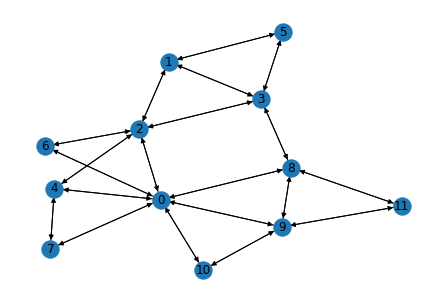

In [27]:
import matplotlib.pyplot as plt
nx_g = example_graph.to_networkx()
pos = nx.kamada_kawai_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True)
plt.show()

### Message Passing of One GraphSage Layer in a mini-batch

The mini-batch contains two seed nodes 4 and 6. If we wish to compute the output representation of node 4 and 6 with a GraphSAGE layer, we actually need the input feature of node 4 and 6 themselves, as well as their neighbors (node 7, 0 and 2):

![Graph](assets/graph_1layer_46.png)

To construct a mini-batch, we can use DGL API: `dgl.in_subgraph`, that takes in a set of nodes and returns a graph consisting of all edges going to one of the given nodes.  Such a graph can exactly describe the computation dependency above.

In [7]:
sampled_node_batch = torch.LongTensor([4, 6])   # These are the nodes whose outputs are to be computed
sampled_graph = dgl.in_subgraph(example_graph, sampled_node_batch)
print(sampled_graph.all_edges())

(tensor([0, 2, 7, 0, 2]), tensor([4, 4, 4, 6, 6]))


The returned subgraph will look like this:

![](assets/in_subgraph_1.png)

Note that it is directed.

Nodes in such a sub graph can have two roles: 
* The output nodes, which only contain the nodes whose outputs are to be computed.
* The input nodes, which contain the neighbors of those nodes.  For models such as GraphSAGE, the output nodes themselves are also input nodes.

DGL further provides a bipartite structure *block* to better reflect this data structure. A sub graph can be easily converted to a block with function `dgl.to_block`.

In [10]:
sampled_block = dgl.to_block(sampled_graph, sampled_node_batch)

def print_block_info(sampled_block):
    sampled_input_nodes = sampled_block.srcdata[dgl.NID]
    print('Node ID of input nodes in original graph:', sampled_input_nodes)

    sampled_output_nodes = sampled_block.dstdata[dgl.NID]
    print('Node ID of output nodes in original graph:', sampled_output_nodes)

    sampled_block_edges_src, sampled_block_edges_dst = sampled_block.all_edges()
    # We need to map the src and dst node IDs in the blocks to the node IDs in the original graph.
    sampled_block_edges_src_mapped = sampled_input_nodes[sampled_block_edges_src]
    sampled_block_edges_dst_mapped = sampled_output_nodes[sampled_block_edges_dst]
    print('Edge connections:', sampled_block_edges_src_mapped, sampled_block_edges_dst_mapped)
    
print_block_info(sampled_block)

Node ID of input nodes in original graph: tensor([4, 6, 0, 2, 7])
Node ID of output nodes in original graph: tensor([4, 6])
Edge connections: tensor([0, 2, 7, 0, 2]) tensor([4, 4, 4, 6, 6])


We can see that the input nodes also include node 4 and 6, which are the output nodes themselves. And the edge connections are preserved (i.e. they map to the same ones in `sampled_graph`).

Essentially, the block will have the following structure.  The input nodes reside on the left and the output nodes reside on the right.  Note that node 4 and 6 appear in both input nodes and output nodes.

![](assets/block1.png)

#### GraphSAGE Layer on Blocks

The sampled block is ensantially a bipartite graph. We have seen in previous example that DGL's built-in class `SAGEConv` works perfectly on whole graph. Does it also function properly on a *Block*? The answer is yes. Acutally all of DGL's neural network layers support working on both homogeneous graphs and bipartite graphs.

In [8]:
import dgl.nn as dglnn
sageconv_module = dglnn.SAGEConv(INPUT_FEATURES, OUTPUT_FEATURES, 'mean', activation=F.relu)

sampled_block_src_features = example_graph.ndata['features'][sampled_block.srcdata[dgl.NID]]
sampled_block_dst_features = example_graph.ndata['features'][sampled_block.dstdata[dgl.NID]]

output_of_sampled_node_batch = sageconv_module(
    sampled_block, (sampled_block_src_features, sampled_block_dst_features))
print(output_of_sampled_node_batch)

NameError: name 'sampled_block' is not defined

#### Writing Your Own Layers on Blocks

The code of writing your own layer that works on blocks is very similar to the one you write for homogeneous graphs, except for a few differences described in the comments.

In [3]:
class SAGEConvBipartite(nn.Module):
    def __init__(self, in_feats, out_feats):
        super().__init__()
        self.W = nn.Linear(2 * in_feats, out_feats)
        
    def forward(self, g, x):
        # Because g is now a bipartite graph, we now need to input tensors, one on the input
        # side and another on the output side.
        x_src, x_dst = x
        
        with g.local_scope():
            # Aggregate input features of neighbors
            g.srcdata['x'] = x_src                                      # ndata here is changed to srcdata
                                                                        # x is also changed to x_src (input side)
            g.update_all(fn.copy_u('x', 'm'), fn.mean('m', 'x_neigh'))
            # Concatenate aggregation with the node representation itself
            x_neigh = g.dstdata['x_neigh']                              # ndata here is changed to dstdata
            x_concat = torch.cat([x_dst, x_neigh], -1)                  # x is changed to x_dst (output side)
            # Pass the concatenation to an MLP
            y = F.relu(self.W(x_concat))
            return y

### Multiple Layers

Now we wish to compute the output of node 4 and 6 from a 2-layer GraphSAGE.  This requires the input features of not only the nodes themselves and their neighbors, but also the neighbors of these neighbors.

![](assets/graph_2layer_46.png)

To compute the 2-layer output of node 4 and 6, we first need to obtain the 1-layer output of node 4 and 6, as well as the neighbors (node 7, 0, and 2).  To obtain the 1-layer output of all these nodes, we again need the input feature of these nodes (node 4, 6, 7, 0, 2) as well as *their* neighbors (node 10, 9, 8, 1, and 3).

Recall that to compute the 2-layer representation of node 4 and 6, the computation dependency on 2nd layer include node 4 and 6 as well as their neighbors:

![](assets/in_subgraph_1.png)

To compute the 1st layer representation of those nodes we further need more dependencies:

![](assets/in_subgraph_2.png)

If we draw the propagation flow as bipartite graphs, they will look like this:

![](assets/block2.png)

We can see that the generation of computation dependency for multi-layer GNNs is a bottom-up process: we start from the output layer, and grows the node set towards the input layer.

The following code directly returns the list of blocks as the computation dependency generation for multi-layer GNNs.

In [4]:
class FullNeighborBlockSampler(object):
    def __init__(self, g, num_layers):
        self.g = g
        self.num_layers = num_layers
        
    def sample(self, seeds):
        blocks = []
        for i in range(self.num_layers):
            sampled_graph = dgl.in_subgraph(self.g, seeds)
            sampled_block = dgl.to_block(sampled_graph, seeds)
            seeds = sampled_block.srcdata[dgl.NID]
            # Because the computation dependency is generated bottom-up, we prepend the new block instead of
            # appending it.
            blocks.insert(0, sampled_block)
            
        return blocks

In [11]:
block_sampler = FullNeighborBlockSampler(example_graph, 2)
sampled_blocks = block_sampler.sample(sampled_node_batch)

print('Block for first layer')
print('---------------------')
print_block_info(sampled_blocks[0])
print()
print('Block for second layer')
print('----------------------')
print_block_info(sampled_blocks[1])

Block for first layer
---------------------
Node ID of input nodes in original graph: tensor([ 4,  6,  0,  2,  7,  8,  9, 10,  1,  3])
Node ID of output nodes in original graph: tensor([4, 6, 0, 2, 7])
Edge connections: tensor([ 0,  2,  7,  0,  2,  2,  4,  6,  7,  8,  9, 10,  0,  4,  6,  1,  3,  0,
         4]) tensor([4, 4, 4, 6, 6, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 7, 7])

Block for second layer
----------------------
Node ID of input nodes in original graph: tensor([4, 6, 0, 2, 7])
Node ID of output nodes in original graph: tensor([4, 6])
Edge connections: tensor([0, 2, 7, 0, 2]) tensor([4, 4, 4, 6, 6])


In [17]:
sampled_blocks[0].ntypes

['_N', '_N']

In [12]:
sampled_blocks[0].srcdata[dgl.NID]

tensor([ 4,  6,  0,  2,  7,  8,  9, 10,  1,  3])

In [13]:
sampled_blocks[0].dstdata[dgl.NID]

tensor([4, 6, 0, 2, 7])

The message propagation is instead a top-down process, as opposed to computation dependency generation: we start from the input layer, and computes the representations towards the output layer.

Now we modify our GraphSAGEModel so it can forward on blocks.

In [ ]:
class SAGENet(nn.Module):
    def __init__(self, n_layers, in_feats, out_feats, hidden_feats=None):
        super().__init__()
        self.convs = nn.ModuleList()
        
        if hidden_feats is None:
            hidden_feats = out_feats
        
        if n_layers == 1:
            self.convs.append(dglnn.SAGEConv(in_feats, out_feats, 'mean'))
        else:
            self.convs.append(dglnn.SAGEConv(in_feats, hidden_feats, 'mean', activation=F.relu))
            for i in range(n_layers - 2):
                self.convs.append(dglnn.SAGEConv(hidden_feats, hidden_feats, 'mean', activation=F.relu))
            self.convs.append(dglnn.SAGEConv(hidden_feats, out_feats, 'mean'))
        
    def forward(self, blocks, input_features):
        """
        blocks : List of blocks generated by block sampler.
        input_features : Input features of the first block.
        """
        h = input_features
        for layer, block in zip(self.convs, blocks):
            h = self.propagate(block, h, layer)
        return h
    
    def propagate(self, block, h, layer):
        # Because GraphSAGE requires not only the features of the neighbors, but also the features
        # of the output nodes themselves on the current layer, we need to copy the output node features
        # from the input side to the output side ourselves to make GraphSAGE work correctly.
        # The output nodes of a block are guaranteed to appear the first in the input nodes, so we can
        # conveniently write like this:
        h_dst = h[:block.number_of_dst_nodes()]
        h = layer(block, (h, h_dst))
        return h

In [ ]:
sagenet = SAGENet(2, INPUT_FEATURES, OUTPUT_FEATURES)

# The input nodes for computing 2-layer GraphSAGE output on the given output nodes can be obtained like this:
sampled_input_nodes = sampled_blocks[0].srcdata[dgl.NID]

# Get the input features.
# In real life we want to copy this to GPU.  But in this hands-on tutorial we don't have GPUs.
sampled_input_features = example_graph.ndata['features'][sampled_input_nodes]

output_of_sampled_node_batch = sagenet(sampled_blocks, sampled_input_features)
print(output_of_sampled_node_batch)

## Neighborhood Sampling

We may notice in the above example that 2-hop neighbors actually almost covered the entire graph.  In real world graphs whose node degrees often follow a power-law distribution (i.e. there would exist a few "hub" nodes with lots of edges), we indeed often observe that for a small set of output nodes from a multi-layer GNN, the input nodes will still cover a large part of the graph.  The whole purpose of saving GPU memory thus fails again in this setting.

Neighborhood sampling offers a solution by *not* taking all neighbors for every node during computation dependency generation.  Instead, we pick a small subset of neighbors and estimate the aggregation of all neighbors from this subset.  This strategy often not only reduces computation and memory consumption, but also improves model generalization.

DGL provides a function `dgl.sampling.sample_neighbors` for uniform sampling a fixed number of neighbors of each node.  One can also change `dgl.sampling.sample_neighbors` to any kind of existing neighborhood sampling algorithm (including your own).

In [ ]:
class NeighborSampler(object):
    def __init__(self, g, num_fanouts):
        """
        num_fanouts : list of fanouts on each layer.
        """
        self.g = g
        self.num_fanouts = num_fanouts
        
    def sample(self, seeds):
        seeds = torch.LongTensor(seeds)
        blocks = []
        for fanout in reversed(self.num_fanouts):
            # We simply switch from in_subgraph to sample_neighbors for neighbor sampling.
            sampled_graph = dgl.sampling.sample_neighbors(self.g, seeds, fanout)
            
            sampled_block = dgl.to_block(sampled_graph, seeds)
            seeds = sampled_block.srcdata[dgl.NID]
            # Because the computation dependency is generated bottom-up, we prepend the new block instead of
            # appending it.
            blocks.insert(0, sampled_block)
            
        return blocks

In [ ]:
block_sampler = NeighborSampler(example_graph, [2, 2])
sampled_blocks = block_sampler.sample(sampled_node_batch)

print('Block for first layer')
print('---------------------')
print_block_info(sampled_blocks[0])
print()
print('Block for second layer')
print('----------------------')
print_block_info(sampled_blocks[1])

We can see that each output node now has at most 2 neighbors.

Code for message passing on blocks generated with neighborhood sampling does not change at all.

In [ ]:
sagenet = SAGENet(2, INPUT_FEATURES, OUTPUT_FEATURES)

# The input nodes for computing 2-layer GraphSAGE output on the given output nodes can be obtained like this:
sampled_input_nodes = sampled_blocks[0].srcdata[dgl.NID]

# Get the input features.
# In real life we want to copy this to GPU.  But in this hands-on tutorial we don't have GPUs.
sampled_input_features = example_graph.ndata['features'][sampled_input_nodes]

output_of_sampled_node_batch = sagenet(sampled_blocks, sampled_input_features)
print(output_of_sampled_node_batch)

### Inference with Models Trained with Neighbor Sampling

Recall that modules such as Dropout or batch normalization have different formulations in training and inference.  The reason was that we do not wish to introduce any randomness during inference or model deployment.  Similarly, we do not want to sample any of the neighbors during inference; aggregation should be performed on all neighbors without sampling to eliminate randomness.  However, directly using the multi-layer `FullNeighborBlockSampler` would still cost a lot of memory even during inference, due to the large number of input nodes being covered.

The solution to this is to compute representations of all nodes on one intermediate layer at a time.  To be more specific, for a multi-layer GraphSAGE model, we first compute the representation of all nodes on the 1st GraphSAGE layer, using a 1-layer `FullNeighborBlockSampler` to take all neighbors into account.  Such representations are computed in minibatches.  After all the representations from the 1st GraphSAGE layer are computed, we start from there and compute the representation of all nodes on the 2nd GraphSAGE layer.  We repeat the process until we go to the last layer.

In [ ]:
import tqdm

def inference_with_sagenet(sagenet, graph, input_features, batch_size):
    block_sampler = FullNeighborBlockSampler(graph, 1)
    h = input_features
    
    with torch.no_grad():
        # We are computing all representations of one layer at a time.
        # The outer loop iterates over GNN layers.
        for conv in sagenet.convs:
            new_h_list = []
            node_ids = torch.arange(graph.number_of_nodes())
            # The inner loop iterates over batch of nodes.
            for batch_start in tqdm.tqdm(range(0, graph.number_of_nodes(), batch_size)):
                # Sample a block with full neighbors of the current node batch
                block = block_sampler.sample(node_ids[batch_start:batch_start+batch_size])[0]
                # Get the necessary input node IDs for this node batch on this layer
                input_node_ids = block.srcdata[dgl.NID]
                # Get the input features
                h_input = h[input_node_ids]
                # Compute the output of this node batch on this layer
                new_h = sagenet.propagate(block, h_input, conv)
                new_h_list.append(new_h)
            # We finished computing all representations on this layer.  We need to compute the
            # representations of next layer.
            h = torch.cat(new_h_list)
        
    return h

In [ ]:
print(inference_with_sagenet(sagenet, example_graph, example_graph.ndata['features'], 2))

## Putting Together

Now let's see how we could apply stochastic training on a node classification task.  We take PubMed dataset as an example.

### Load Dataset

In [1]:
import dgl.data

dataset = dgl.data.citation_graph.load_pubmed()

# Set features and labels for each node
graph = dgl.graph(dataset.graph)
graph.ndata['features'] = torch.FloatTensor(dataset.features)
graph.ndata['labels'] = torch.LongTensor(dataset.labels)
in_feats = dataset.features.shape[1]
num_labels = dataset.num_labels

# Find the node IDs in the training, validation, and test set.
train_nid = dataset.train_mask.nonzero()[0]
val_nid = dataset.val_mask.nonzero()[0]
test_nid = dataset.test_mask.nonzero()[0]

Extracting file to C:\Users\smile\.dgl/pubmed
Finished data loading and preprocessing.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000


NameError: name 'torch' is not defined

The [Amazon product co-purchasing network](https://ogb.stanford.edu/docs/nodeprop/#ogbn-products) from [Open Graph Benchmark](https://ogb.stanford.edu/).

In [ ]:
'''
from ogb.nodeproppred import DglNodePropPredDataset

data = DglNodePropPredDataset(name='ogbn-products')
splitted_idx = data.get_idx_split()
graph, labels = data[0]
labels = labels[:, 0]
graph = dgl.as_heterograph(graph)

graph.ndata['features'] = graph.ndata['feat']
graph.ndata['labels'] = labels
in_feats = graph.ndata['features'].shape[1]
num_labels = len(torch.unique(labels))

# Find the node IDs in the training, validation, and test set.
train_nid, val_nid, test_nid = splitted_idx['train'], splitted_idx['valid'], splitted_idx['test']
print('|V|={}, |E|={}'.format(graph.number_of_nodes(), graph.number_of_edges()))
print('train: {}, valid: {}, test: {}'.format(len(train_nid), len(val_nid), len(test_nid)))
'''

### Define Neighbor Sampler

We can reuse our neighbor sampler code above.

In [ ]:
neighbor_sampler = NeighborSampler(graph, [10, 25])

### Define DataLoader

PyTorch generates minibatches with a `DataLoader` object.  We can also use it.

Note that to compute the output of a minibatch of nodes, we need a list of blocks described as above.  Therefore, we need to change the `collate_fn` argument which defines how to compose different individual examples into a minibatch.

The benefit of using Pytorch Dataloader is that we can take advantage of multiprocessing in DataLoader to generate mini-batches in parallel.

In [ ]:
import torch.utils.data

BATCH_SIZE = 1000

train_dataloader = torch.utils.data.DataLoader(
    train_nid, batch_size=BATCH_SIZE, collate_fn=neighbor_sampler.sample, shuffle=True)

### Define Model and Optimizer

In [ ]:
HIDDEN_FEATURES = 50
model = SAGENet(2, in_feats, num_labels, HIDDEN_FEATURES)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

### Evaluation

In [ ]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

### Training Loop

In [ ]:
import tqdm

NUM_EPOCHS = 50
EVAL_BATCH_SIZE = 10000
for epoch in range(NUM_EPOCHS):
    sagenet.train()
    for blocks in tqdm.tqdm(train_dataloader):
        input_nodes = blocks[0].srcdata[dgl.NID]
        output_nodes = blocks[-1].dstdata[dgl.NID]
        
        input_features = graph.ndata['features'][input_nodes]
        output_labels = graph.ndata['labels'][output_nodes]
        
        output_predictions = model(blocks, input_features)
        loss = F.cross_entropy(output_predictions, output_labels)
        opt.zero_grad()
        loss.backward()
        opt.step()

    if (epoch + 1) % 5 == 0:
        sagenet.eval()
        all_predictions = inference_with_sagenet(model, graph, graph.ndata['features'], EVAL_BATCH_SIZE)

        val_predictions = all_predictions[val_nid]
        val_labels = graph.ndata['labels'][val_nid]
        test_predictions = all_predictions[test_nid]
        test_labels = graph.ndata['labels'][test_nid]

        print('Validation acc:', compute_accuracy(val_predictions, val_labels),
              'Test acc:', compute_accuracy(test_predictions, test_labels))

In [28]:
500000*360

180000000